# **Logistic Regression** 

A logistic regression with both L1 and L2 regularization will be implemented. The class LogisticRegression will have the following API:

* `__init__(alpha, tol, max_iter, theta_init, penalty, lambd)`
* `sigmoid(x)`
* `compute_cost(theta, X, y)`
* `compute_gradient(theta, X, y)`
* `has_converged(theta_old, theta_new)`
* `fit(X, y)`
* `predict_proba(X)`
* `predict(X)`


### **Sigmoid Function**

The sigmoid function $\sigma(x)$ is mathematically defined as follows.

> $\sigma(x) = \frac{1}{1\ +\ \text{exp}(-x)}$


### **Cost Function**

The cost function computes the scalar cost for a given $\theta$ vector.

> $
\mathcal{L}({\theta}) = -\sum_{i =1}^N [ y_i\log(h_{{\theta}}({x}_i)) + (1 - y_i)\log(1 - h_{{\theta}}({x}_i))]
$

where
> $
h_{\theta}(x_{i}) = \sigma(\theta^{T}x_{i})
$


L1 Regularization Loss:
>$
\mathcal{L1}({\theta}) = \mathcal{L}({\theta}) + \lambda \sum_{j = 1}^D  |{\theta}_j|
$

L2 Regularization Loss:
>$
\mathcal{L2}({\theta}) = \mathcal{L}({\theta}) + \lambda \sum_{j = 1}^D  {\theta}_j^2 
$

$N$ is the number of training samples and $D$ is the number of features (excluding the intercept term). $\theta$ is a $D + 1$ dimensional vector, with the first element being the intercept term.

In [1]:
import random 
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
from numpy.linalg import *
np.random.seed(42)

import dill
import base64

In [2]:
class LogisticRegression:

    """
    Logistic Regression (aka logit, MaxEnt) classifier.

    Parameters
    ----------
    alpha: float, default=0.01
        Learning rate
    tol : float, default=0.0001
        Tolerance for stopping criteria
    max_iter : int, default=10000
        Maximum number of iterations of gradient descent
    theta_init: None (or) numpy.ndarray of shape (D + 1,)
        The initial weights; if None, all weights will be zero by default
    penalty : string, default = None
        The type of regularization. The other acceptable options are l1 and l2
    lambd : float, default = 1.0
        The parameter regularisation constant (i.e. lambda)

    Attributes
    ----------
    theta_ : numpy.ndarray of shape (D + 1,)
        The value of the coefficients after gradient descent has converged
        or the number of iterations hit the maximum limit
    hist_theta_ : numpy.ndarray of shape (num_iter, D + 1) where num_iter is the number of gradient descent iterations
        Stores theta_ after every gradient descent iteration
    hist_cost_ : numpy.ndarray of shape (num_iter,) where num_iter is the number of gradient descent iterations
        Stores cost after every gradient descent iteration
    
    """

    def __init__(self, alpha=0.01, tol=0.0001, max_iter=10000, theta_init=None, penalty = None, lambd = 1.0):

        self.alpha = alpha
        self.tol = tol
        self.max_iter = max_iter
        self.theta_init = theta_init
        self.penalty = penalty
        self.lambd = lambd

        self.theta_ = None
        self.hist_cost_ = None
        self.hist_theta_ = None

    def sigmoid(self, x):

        """
        Compute the sigmoid value of the argument.

        Parameters
        ----------
        x: numpy.ndarray

        Returns
        -------
        out: numpy.ndarray
            The sigmoid value of x
        """

        return 1/(1 + np.exp(-x))

    def compute_cost(self, theta, X, y):

        """
        Compute the cost/objective function.

        Parameters
        ----------
        theta: numpy.ndarray of shape (D + 1,)
            The coefficients
        X: numpy.ndarray of shape (N, D + 1)
            The features matrix
        y: numpy.ndarray of shape (N,)
            The target variable array

        Returns
        -------
        cost: float
            The cost as a scalar value
        """
        
        z = np.matmul(X, theta) # (N, )
        h = self.sigmoid(z) # (N, )

        L = -np.sum(np.matmul(y.T, np.log(h)) + np.matmul((1-y).T, np.log(1-h)))
        L1 = L + self.lambd * np.sum(np.abs(theta[1:]))
        L2 = L + self.lambd * np.sum(np.square(theta[1:]))

        if self.penalty == 'l1': return L1
        elif self.penalty == 'l2': return L2
        else: return L
        
    def compute_gradient(self, theta, X, y):

        """
        Compute the gradient of the cost function.

        Parameters
        ----------
        theta: numpy.ndarray of shape (D + 1,)
            The coefficients
        X: numpy.ndarray of shape (N, D + 1)
            The features matrix
        y: numpy.ndarray of shape (N,)
            The target variable array

        Returns
        -------
        gradient: numpy.ndarray of shape (D + 1,)
            The gradient values
        """

        z = np.matmul(X, theta) # (N, )
        h = self.sigmoid(z) # (N, )

        dL = np.matmul(X.T, (h-y)) # (D+1, )
        dL1 = dL + np.insert(self.lambd*np.sign(theta[1:]), 0, 0)
        dL2 = dL + np.insert(2*self.lambd*theta[1:], 0, 0)

        if self.penalty == 'l1': return dL1
        elif self.penalty == 'l2': return dL2
        else: return dL

    def has_converged(self, theta_old, theta_new):

        """
        Return whether gradient descent has converged.

        Parameters
        ----------
        theta_old: numpy.ndarray of shape (D + 1,)
            The weights prior to the update by gradient descent
        theta_new: numpy.ndarray of shape (D + 1,)
            The weights after the update by gradient descent
        
        Returns
        -------
        converged: bool
            Whether gradient descent converged or not
        """

        norm_2 = np.linalg.norm((theta_old - theta_new),2)

        if norm_2 <= self.tol: return True
        else: return False

    def fit(self, X, y):

        """
        Compute the coefficients using gradient descent and store them as theta_.

        Parameters
        ----------
        X: numpy.ndarray of shape (N, D)
            The features matrix
        y: numpy.ndarray of shape (N,)
            The target variable array

        Returns
        -------
        Nothing
        """

        N, D = X.shape

        ones_col = np.ones((N, 1))
        X = np.hstack((ones_col, X))
        
        if self.theta_init is None:
            theta_old = np.zeros((D + 1,))
        else:
            theta_old = self.theta_init

        self.hist_theta_ = np.array([theta_old])
        cost = self.compute_cost(theta_old, X, y)
        self.hist_cost_ = np.array([cost])
        
        for i in range(self.max_iter):
          grad = self.compute_gradient(theta_old, X, y)
          theta_new = theta_old - self.alpha*grad
          cost = self.compute_cost(theta_old, X, y)
          self.hist_cost_ = np.vstack([self.hist_cost_, cost])
          self.hist_theta_ = np.vstack([self.hist_theta_, theta_new])
          if self.has_converged(theta_new, theta_old):
              break
          theta_old = theta_new
        self.theta = theta_new

    def predict_proba(self, X):

        """
        Predict the probabilities that the data points in X belong to class 1.

        Parameters
        ----------
        X: numpy.ndarray of shape (N, D)
            The features matrix

        Returns
        -------
        y_hat: numpy.ndarray of shape (N,)
            The predicted probabilities that the data points in X belong to class 1
        """

        N = X.shape[0]
        X = np.hstack((np.ones((N, 1)), X))
        
        return self.sigmoid(np.matmul(X, self.theta))

    def predict(self, X):

        """
        Predict the classes of the data points in X.

        Parameters
        ----------
        X: numpy.ndarray of shape (N, D)
            The features matrix

        Returns
        -------
        y_pred: numpy.ndarray of shape (N,)
            The predicted class of the data points in X
        """

        return self.predict_proba(X) > 0.5

In [3]:
!wget https://scipython.com/static/media/uploads/blog/logistic_regression/linpts.txt

--2022-02-23 04:07:27--  https://scipython.com/static/media/uploads/blog/logistic_regression/linpts.txt
Resolving scipython.com (scipython.com)... 3.130.82.216
Connecting to scipython.com (scipython.com)|3.130.82.216|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8000 (7.8K) [text/plain]
Saving to: ‘linpts.txt.1’

linpts.txt.1        100%[===================>]   7.81K  --.-KB/s    in 0s      

2022-02-23 04:07:28 (184 MB/s) - ‘linpts.txt.1’ saved [8000/8000]



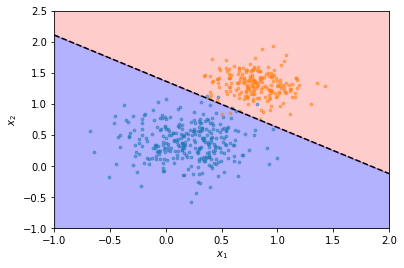

In [14]:
pts = np.loadtxt('linpts.txt')

X = pts[:,:2]
y = pts[:,2].astype('int')

model = LogisticRegression()
model.fit(X, y)
b = model.theta[0]
w1, w2 = model.theta[1], model.theta[2]

c = -b/w2
m = -w1/w2

xmin, xmax = -1, 2
ymin, ymax = -1, 2.5
xd = np.array([xmin, xmax])
yd = m*xd + c

plt.plot(xd, yd, 'k', ls='--')

plt.fill_between(xd, yd, ymin, color='b', alpha=0.3)
plt.fill_between(xd, yd, ymax, color='r', alpha=0.2)
plt.scatter(*X[y==0].T, s=8, alpha=0.5)
plt.scatter(*X[y==1].T, s=8, alpha=0.5)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.ylabel(r'$x_2$')
plt.xlabel(r'$x_1$')

plt.show()